In [43]:
import warnings
warnings.filterwarnings('ignore')

# Import our dependencies
import numpy as np
import pandas as pd
import xarray as xr

import os
from dotenv import load_dotenv
from pymongo import MongoClient

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_samples, silhouette_score

import arviz as az
import holoviews as hv
import hvplot.pandas
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import seaborn as sns
import sweetviz as sv

In [2]:
# load the config from the .env file
load_dotenv()
MONGODB_URI = os.environ['MONGODB_URI']

In [3]:
# Connect to the database engine
client = MongoClient(MONGODB_URI)

In [4]:
# connect to the project db
db = client['ExpectLife']

In [5]:
# get a reference to the data collection
data_list = db['ML_for_clustering_list']

In [6]:
# Create a dataframe from the collection
combined_df = pd.DataFrame(list(data_list.find()))
combined_df

_id   country_year   country  Life Expectancy  \
0     63bb6ea91ab4d7f0ea5c718a   Albania 2000   Albania             75.0   
1     63bb6ea91ab4d7f0ea5c718b   Albania 2001   Albania             75.0   
2     63bb6ea91ab4d7f0ea5c718c   Albania 2002   Albania             75.0   
3     63bb6ea91ab4d7f0ea5c718d   Albania 2003   Albania             75.0   
4     63bb6ea91ab4d7f0ea5c718e   Albania 2004   Albania             80.0   
...                        ...            ...       ...              ...   
3375  63bb6eab1ab4d7f0ea5c7eb9  Zimbabwe 2015  Zimbabwe             60.0   
3376  63bb6eab1ab4d7f0ea5c7eba  Zimbabwe 2016  Zimbabwe             65.0   
3377  63bb6eab1ab4d7f0ea5c7ebb  Zimbabwe 2017  Zimbabwe             65.0   
3378  63bb6eab1ab4d7f0ea5c7ebc  Zimbabwe 2018  Zimbabwe             65.0   
3379  63bb6eab1ab4d7f0ea5c7ebd  Zimbabwe 2019  Zimbabwe             65.0   

      Alcohol Consumption  Tobacco Consumption  GDP per Capita  \
0                    6.57                35.00         1960.88   
1                    6.79                34.26         2143.53   
2                    7.00                33.52         2247.50   
3                    7.22                32.78         2380.64   
4                    7.43                32.04         2522.45   
...                   ...                  ...             ...   
3375                 4.92                13.60         1410.33   
3376                 4.92                13.10         1393.72   
3377                 4.67                12.60         1421.24   
3378                 4.67                12.10         1462.59   
3379                 4.67                12.10         1342.99   

      Goverment Expenditure per Capita  Private Expenditure per Capita  \
0                               105.46                          166.59   
1                               115.80                          173.49   
2                               117.77                          187.68   
3                               130.03                          185.78   
4                               149.14                          188.59   
...                                ...                             ...   
3375                             41.57                          109.67   
3376                             50.21                          105.08   
3377                             54.33                          102.42   
3378                             86.31                          115.13   
3379                             36.75                          110.07   

      Male Survival %  Female Survival %  sss_depth  Population  \
0               80.14              88.48          2     3195.71   
1               80.53              88.70          2     3168.33   
2               80.96              88.93          2     3138.90   
3               81.33              89.21          2     3108.21   
4               81.71              89.43          2     3077.78   
...               ...                ...        ...         ...   
3375            44.73              53.85          1    14006.29   
3376            45.83              55.33          1    14303.59   
3377            46.19              56.40          1    14601.82   
3378            47.66              57.58          1    14900.38   
3379            46.79              57.73          1    15203.99   

                                            system_type  
0     ['Universal medical benefits','Social insuranc...  
1     ['Universal medical benefits','Social insuranc...  
2     ['Universal medical benefits','Social insuranc...  
3     ['Universal medical benefits','Social insuranc...  
4     ['Universal medical benefits','Social insuranc...  
...                                                 ...  
3375  ['Employer-liability system (cash sickness and...  
3376  ['Employer-liability system (cash sickness and...  
3377  ['Employer-liability system (cash sickness and...  
3378  ['Employer-liability system (cash sicknes

In [7]:
# Drop the na, database id data, and refresh the index
combined_df = combined_df.dropna()
combined_df = combined_df.drop(['_id'], axis=1)
combined_df = combined_df.reset_index(drop=True)
combined_df

country_year   country  Life Expectancy  Alcohol Consumption  \
0      Albania 2000   Albania             75.0                 6.57   
1      Albania 2001   Albania             75.0                 6.79   
2      Albania 2002   Albania             75.0                 7.00   
3      Albania 2003   Albania             75.0                 7.22   
4      Albania 2004   Albania             80.0                 7.43   
...             ...       ...              ...                  ...   
3374  Zimbabwe 2015  Zimbabwe             60.0                 4.92   
3375  Zimbabwe 2016  Zimbabwe             65.0                 4.92   
3376  Zimbabwe 2017  Zimbabwe             65.0                 4.67   
3377  Zimbabwe 2018  Zimbabwe             65.0                 4.67   
3378  Zimbabwe 2019  Zimbabwe             65.0                 4.67   

      Tobacco Consumption  GDP per Capita  Goverment Expenditure per Capita  \
0                   35.00         1960.88                            105.46   
1                   34.26         2143.53                            115.80   
2                   33.52         2247.50                            117.77   
3                   32.78         2380.64                            130.03   
4                   32.04         2522.45                            149.14   
...                   ...             ...                               ...   
3374                13.60         1410.33                             41.57   
3375                13.10         1393.72                             50.21   
3376                12.60         1421.24                             54.33   
3377                12.10         1462.59                             86.31   
3378                12.10         1342.99                             36.75   

      Private Expenditure per Capita  Male Survival %  Female Survival %  \
0                             166.59            80.14              88.48   
1                             173.49            80.53              88.70   
2                             187.68            80.96              88.93   
3                             185.78            81.33              89.21   
4                             188.59            81.71              89.43   
...                              ...              ...                ...   
3374                          109.67            44.73              53.85   
3375                          105.08            45.83              55.33   
3376                          102.42            46.19              56.40   
3377                          115.13            47.66              57.58   
3378                          110.07            46.79              57.73   

      sss_depth  Population                                        system_type  
0             2     3195.71  ['Universal medical benefits','Social insuranc...  
1             2     3168.33  ['Universal medical benefits','Social insuranc...  
2             2     3138.90  ['Universal medical benefits','Social insuranc...  
3             2     3108.21  ['Universal medical benefits','Social insuranc...  
4             2     3077.78  ['Universal medical benefits','Social insuranc...  
...         ...         ...                                                ...  
3374          1    14006.29  ['Employer-liability system (cash sickness and...  
3375          1    14303.59  ['Employer-liability system (cash sickness and...  
3376          1    14601.82  ['Employer-liability system (cash sickness and...  
3377          1    14900.38  ['Employer-liability system (cash sickness and...  
3378          1    15203.99  ['Employer-liability system (cash sickness and...  

[3379 rows x 13 columns]

In [8]:
# Create a new DataFrame for the country-year.
country_year_df = pd.DataFrame()
country_year_df['country_year'] = combined_df['country_year']
country_year_df

country_year
0      Albania 2000
1      Albania 2001
2      Albania 2002
3      Albania 2003
4      Albania 2004
...             ...
3374  Zimbabwe 2015
3375  Zimbabwe 2016
3376  Zimbabwe 2017
3377  Zimbabwe 2018
3378  Zimbabwe 2019

[3379 rows x 1 columns]

In [9]:
# Set the DataFrame index to the country names to get them out of the way
combined_df = combined_df.drop(['country_year'], axis=1)
combined_df

country  Life Expectancy  Alcohol Consumption  Tobacco Consumption  \
0      Albania             75.0                 6.57                35.00   
1      Albania             75.0                 6.79                34.26   
2      Albania             75.0                 7.00                33.52   
3      Albania             75.0                 7.22                32.78   
4      Albania             80.0                 7.43                32.04   
...        ...              ...                  ...                  ...   
3374  Zimbabwe             60.0                 4.92                13.60   
3375  Zimbabwe             65.0                 4.92                13.10   
3376  Zimbabwe             65.0                 4.67                12.60   
3377  Zimbabwe             65.0                 4.67                12.10   
3378  Zimbabwe             65.0                 4.67                12.10   

      GDP per Capita  Goverment Expenditure per Capita  \
0            1960.88                            105.46   
1            2143.53                            115.80   
2            2247.50                            117.77   
3            2380.64                            130.03   
4            2522.45                            149.14   
...              ...                               ...   
3374         1410.33                             41.57   
3375         1393.72                             50.21   
3376         1421.24                             54.33   
3377         1462.59                             86.31   
3378         1342.99                             36.75   

      Private Expenditure per Capita  Male Survival %  Female Survival %  \
0                             166.59            80.14              88.48   
1                             173.49            80.53              88.70   
2                             187.68            80.96              88.93   
3                             185.78            81.33              89.21   
4                             188.59            81.71              89.43   
...                              ...              ...                ...   
3374                          109.67            44.73              53.85   
3375                          105.08            45.83              55.33   
3376                          102.42            46.19              56.40   
3377                          115.13            47.66              57.58   
3378                          110.07            46.79              57.73   

      sss_depth  Population                                        system_type  
0             2     3195.71  ['Universal medical benefits','Social insuranc...  
1             2     3168.33  ['Universal medical benefits','Social insuranc...  
2             2     3138.90  ['Universal medical benefits','Social insuranc...  
3             2     3108.21  ['Universal medical benefits','Social insuranc...  
4             2     3077.78  ['Universal medical benefits','Social insuranc...  
...         ...         ...                                                ...  
3374          1    14006.29  ['Employer-liability system (cash sickness and...  
3375          1    14303.59  ['Employer-liability system (cash sickness and...  
3376          1    14601.82  ['Employer-liability system (cash sickness and...  
3377          1    14900.38  ['Employer-liability system (cash sickness and...  
3378          1    15203.99  ['Employer-liability system (cash sickness and...  

[3379 rows x 12 columns]

In [10]:
# Create a new DataFrame for the country names.  Apply the country names as the new index for later merging.
country_df = pd.DataFrame()
country_df['country'] = combined_df['country']
country_df

country
0      Albania
1      Albania
2      Albania
3      Albania
4      Albania
...        ...
3374  Zimbabwe
3375  Zimbabwe
3376  Zimbabwe
3377  Zimbabwe
3378  Zimbabwe

[3379 rows x 1 columns]

In [11]:
# Set the DataFrame index to the country names to get them out of the way
combined_df = combined_df.drop(['country'], axis=1)
combined_df

Life Expectancy  Alcohol Consumption  Tobacco Consumption  \
0                75.0                 6.57                35.00   
1                75.0                 6.79                34.26   
2                75.0                 7.00                33.52   
3                75.0                 7.22                32.78   
4                80.0                 7.43                32.04   
...               ...                  ...                  ...   
3374             60.0                 4.92                13.60   
3375             65.0                 4.92                13.10   
3376             65.0                 4.67                12.60   
3377             65.0                 4.67                12.10   
3378             65.0                 4.67                12.10   

      GDP per Capita  Goverment Expenditure per Capita  \
0            1960.88                            105.46   
1            2143.53                            115.80   
2            2247.50                            117.77   
3            2380.64                            130.03   
4            2522.45                            149.14   
...              ...                               ...   
3374         1410.33                             41.57   
3375         1393.72                             50.21   
3376         1421.24                             54.33   
3377         1462.59                             86.31   
3378         1342.99                             36.75   

      Private Expenditure per Capita  Male Survival %  Female Survival %  \
0                             166.59            80.14              88.48   
1                             173.49            80.53              88.70   
2                             187.68            80.96              88.93   
3                             185.78            81.33              89.21   
4                             188.59            81.71              89.43   
...                              ...              ...                ...   
3374                          109.67            44.73              53.85   
3375                          105.08            45.83              55.33   
3376                          102.42            46.19              56.40   
3377                          115.13            47.66              57.58   
3378                          110.07            46.79              57.73   

      sss_depth  Population                                        system_type  
0             2     3195.71  ['Universal medical benefits','Social insuranc...  
1             2     3168.33  ['Universal medical benefits','Social insuranc...  
2             2     3138.90  ['Universal medical benefits','Social insuranc...  
3             2     3108.21  ['Universal medical benefits','Social insuranc...  
4             2     3077.78  ['Universal medical benefits','Social insuranc...  
...         ...         ...                                                ...  
3374          1    14006.29  ['Employer-liability system (cash sickness and...  
3375          1    14303.59  ['Employer-liability system (cash sickness and...  
3376          1    14601.82  ['Employer-liability system (cash sickness and...  
3377          1    14900.38  ['Employer-liability system (cash sickness and...  
3378          1    15203.99  ['Employer-liability system (cash sickness and...  

[3379 rows x 11 columns]

# Encoding

In [13]:
# Use get_dummies() to create variables for text features.
encode_df = pd.get_dummies(combined_df, columns=['system_type'])
encode_df

Life Expectancy  Alcohol Consumption  Tobacco Consumption  \
0                75.0                 6.57                35.00   
1                75.0                 6.79                34.26   
2                75.0                 7.00                33.52   
3                75.0                 7.22                32.78   
4                80.0                 7.43                32.04   
...               ...                  ...                  ...   
3374             60.0                 4.92                13.60   
3375             65.0                 4.92                13.10   
3376             65.0                 4.67                12.60   
3377             65.0                 4.67                12.10   
3378             65.0                 4.67                12.10   

      GDP per Capita  Goverment Expenditure per Capita  \
0            1960.88                            105.46   
1            2143.53                            115.80   
2            2247.50                            117.77   
3            2380.64                            130.03   
4            2522.45                            149.14   
...              ...                               ...   
3374         1410.33                             41.57   
3375         1393.72                             50.21   
3376         1421.24                             54.33   
3377         1462.59                             86.31   
3378         1342.99                             36.75   

      Private Expenditure per Capita  Male Survival %  Female Survival %  \
0                             166.59            80.14              88.48   
1                             173.49            80.53              88.70   
2                             187.68            80.96              88.93   
3                             185.78            81.33              89.21   
4                             188.59            81.71              89.43   
...                              ...              ...                ...   
3374                          109.67            44.73              53.85   
3375                          105.08            45.83              55.33   
3376                          102.42            46.19              56.40   
3377                          115.13            47.66              57.58   
3378                          110.07            46.79              57.73   

      sss_depth  Population  ...  \
0             2     3195.71  ...   
1             2     3168.33  ...   
2             2     3138.90  ...   
3             2     3108.21  ...   
4             2     3077.78  ...   
...         ...         ...  ...   
3374          1    14006.29  ...   
3375          1    14303.59  ...   
3376          1    14601.82  ...   
3377          1    14900.38  ...   
3378          1    15203.99  ...   

      system_type_['Universal medical benefits','Social insurance (cash benefits)','Social assistance (parental leave)']  \
0                                                     0                                                                    
1                                                     0                                                                    
2                                                     0                                                                    
3                                                     0                                                                    
4                                                     0                                                                    
...                                                 ...                                                                    
3374                                                  0                                                                    
3375                                                  0                                                                    
3376                                      

In [14]:
# Collect the column labels so they can be reapplied after data scaling
col_names = encode_df.columns.tolist()

# Scaling

In [15]:
# Standardize the data with MinMaxScaler().
scaler = MinMaxScaler()

encode_scaled_nda = scaler.fit_transform(encode_df)
encode_scaled_nda

array([[0.75      , 0.32932331, 0.48382126, ..., 0.        , 0.        ,
        0.        ],
       [0.75      , 0.34035088, 0.47241911, ..., 0.        , 0.        ,
        0.        ],
       [0.75      , 0.35087719, 0.46101695, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.5       , 0.23408521, 0.13867488, ..., 0.        , 0.        ,
        0.        ],
       [0.5       , 0.23408521, 0.13097072, ..., 0.        , 0.        ,
        0.        ],
       [0.5       , 0.23408521, 0.13097072, ..., 0.        , 0.        ,
        0.        ]])

In [16]:
# Convert the scaled-encoded data back to a DataFrame (nda = Numpy Data Array)

scale_encode_df = pd.DataFrame(encode_scaled_nda, index=encode_df.index)
scale_encode_df

0         1         2         3         4         5         6    \
0     0.750  0.329323  0.483821  0.015208  0.016982  0.028169  0.857642   
1     0.750  0.340351  0.472419  0.016837  0.018651  0.029357  0.862694   
2     0.750  0.350877  0.461017  0.017763  0.018969  0.031800  0.868264   
3     0.750  0.361905  0.449615  0.018950  0.020949  0.031473  0.873057   
4     0.875  0.372431  0.438213  0.020215  0.024034  0.031957  0.877979   
...     ...       ...       ...       ...       ...       ...       ...   
3374  0.375  0.246617  0.154083  0.010300  0.006666  0.018367  0.398964   
3375  0.500  0.246617  0.146379  0.010151  0.008061  0.017577  0.413212   
3376  0.500  0.234085  0.138675  0.010397  0.008727  0.017119  0.417876   
3377  0.500  0.234085  0.130971  0.010766  0.013890  0.019307  0.436917   
3378  0.500  0.234085  0.130971  0.009699  0.005888  0.018436  0.425648   

           7     8         9    ...  91   92   93   94   95   96   97   98   \
0     0.904864  0.25  0.002199  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.907644  0.25  0.002179  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     0.910550  0.25  0.002159  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
3     0.914087  0.25  0.002137  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
4     0.916867  0.25  0.002116  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
...        ...   ...       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
3374  0.467340  0.00  0.009814  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3375  0.486039  0.00  0.010023  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3376  0.499558  0.00  0.010233  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3377  0.514466  0.00  0.010443  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3378  0.516361  0.00  0.010657  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

      99   100  
0     0.0  0.0  
1     0.0  0.0  
2     0.0  0.0  
3     0.0  0.0  
4     0.0  0.0  
...   ...  ...  
3374  0.0  0.0  
3375  0.0  0.0  
3376  0.0  0.0  
3377  0.0  0.0  
3378  0.0  0.0  

[3379 rows x 101 columns]

In [17]:
# Apply the column labels to ensure the data is properly identified
scale_encode_df = scale_encode_df.set_axis(col_names, axis=1)
scale_encode_df

Life Expectancy  Alcohol Consumption  Tobacco Consumption  \
0               0.750             0.329323             0.483821   
1               0.750             0.340351             0.472419   
2               0.750             0.350877             0.461017   
3               0.750             0.361905             0.449615   
4               0.875             0.372431             0.438213   
...               ...                  ...                  ...   
3374            0.375             0.246617             0.154083   
3375            0.500             0.246617             0.146379   
3376            0.500             0.234085             0.138675   
3377            0.500             0.234085             0.130971   
3378            0.500             0.234085             0.130971   

      GDP per Capita  Goverment Expenditure per Capita  \
0           0.015208                          0.016982   
1           0.016837                          0.018651   
2           0.017763                          0.018969   
3           0.018950                          0.020949   
4           0.020215                          0.024034   
...              ...                               ...   
3374        0.010300                          0.006666   
3375        0.010151                          0.008061   
3376        0.010397                          0.008727   
3377        0.010766                          0.013890   
3378        0.009699                          0.005888   

      Private Expenditure per Capita  Male Survival %  Female Survival %  \
0                           0.028169         0.857642           0.904864   
1                           0.029357         0.862694           0.907644   
2                           0.031800         0.868264           0.910550   
3                           0.031473         0.873057           0.914087   
4                           0.031957         0.877979           0.916867   
...                              ...              ...                ...   
3374                        0.018367         0.398964           0.467340   
3375                        0.017577         0.413212           0.486039   
3376                        0.017119         0.417876           0.499558   
3377                        0.019307         0.436917           0.514466   
3378                        0.018436         0.425648           0.516361   

      sss_depth  Population  ...  \
0          0.25    0.002199  ...   
1          0.25    0.002179  ...   
2          0.25    0.002159  ...   
3          0.25    0.002137  ...   
4          0.25    0.002116  ...   
...         ...         ...  ...   
3374       0.00    0.009814  ...   
3375       0.00    0.010023  ...   
3376       0.00    0.010233  ...   
3377       0.00    0.010443  ...   
3378       0.00    0.010657  ...   

      system_type_['Universal medical benefits','Social insurance (cash benefits)','Social assistance (parental leave)']  \
0                                                   0.0                                                                    
1                                                   0.0                                                                    
2                                                   0.0                                                                    
3                                                   0.0                                                                    
4                                                   0.0                                                                    
...                                                 ...                                                                    
3374                                                0.0                                                                    
3375                                                0.0                                                                    
3376                                      

## Feature Selection

In [18]:
# Define the variance threshold (1%)
sel = VarianceThreshold(threshold=0.01)

# Apply the variance threshold to the scale_encode_df DataFrame
new_se = sel.fit_transform(scale_encode_df)

In [19]:
# Create feature-reduce DataFrame
new_se_df = pd.DataFrame(new_se, index=scale_encode_df.index)
new_se_df

0         1         2         3         4         5         6     7   \
0     0.750  0.329323  0.483821  0.015208  0.016982  0.857642  0.904864  0.25   
1     0.750  0.340351  0.472419  0.016837  0.018651  0.862694  0.907644  0.25   
2     0.750  0.350877  0.461017  0.017763  0.018969  0.868264  0.910550  0.25   
3     0.750  0.361905  0.449615  0.018950  0.020949  0.873057  0.914087  0.25   
4     0.875  0.372431  0.438213  0.020215  0.024034  0.877979  0.916867  0.25   
...     ...       ...       ...       ...       ...       ...       ...   ...   
3374  0.375  0.246617  0.154083  0.010300  0.006666  0.398964  0.467340  0.00   
3375  0.500  0.246617  0.146379  0.010151  0.008061  0.413212  0.486039  0.00   
3376  0.500  0.234085  0.138675  0.010397  0.008727  0.417876  0.499558  0.00   
3377  0.500  0.234085  0.130971  0.010766  0.013890  0.436917  0.514466  0.00   
3378  0.500  0.234085  0.130971  0.009699  0.005888  0.425648  0.516361  0.00   

            8    9   ...   11   12   13   14   15   16   17   18   19   20  
0     0.002199  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
1     0.002179  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
2     0.002159  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
3     0.002137  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
4     0.002116  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
...        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
3374  0.009814  1.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3375  0.010023  1.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3376  0.010233  1.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3377  0.010443  1.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3378  0.010657  1.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[3379 rows x 21 columns]

In [20]:
# Apply the column labels to the feature-reduced DataFrame
new_se_df.columns = sel.get_feature_names_out(col_names)
new_se_df

Life Expectancy  Alcohol Consumption  Tobacco Consumption  \
0               0.750             0.329323             0.483821   
1               0.750             0.340351             0.472419   
2               0.750             0.350877             0.461017   
3               0.750             0.361905             0.449615   
4               0.875             0.372431             0.438213   
...               ...                  ...                  ...   
3374            0.375             0.246617             0.154083   
3375            0.500             0.246617             0.146379   
3376            0.500             0.234085             0.138675   
3377            0.500             0.234085             0.130971   
3378            0.500             0.234085             0.130971   

      GDP per Capita  Goverment Expenditure per Capita  Male Survival %  \
0           0.015208                          0.016982         0.857642   
1           0.016837                          0.018651         0.862694   
2           0.017763                          0.018969         0.868264   
3           0.018950                          0.020949         0.873057   
4           0.020215                          0.024034         0.877979   
...              ...                               ...              ...   
3374        0.010300                          0.006666         0.398964   
3375        0.010151                          0.008061         0.413212   
3376        0.010397                          0.008727         0.417876   
3377        0.010766                          0.013890         0.436917   
3378        0.009699                          0.005888         0.425648   

      Female Survival %  sss_depth  Population  \
0              0.904864       0.25    0.002199   
1              0.907644       0.25    0.002179   
2              0.910550       0.25    0.002159   
3              0.914087       0.25    0.002137   
4              0.916867       0.25    0.002116   
...                 ...        ...         ...   
3374           0.467340       0.00    0.009814   
3375           0.486039       0.00    0.010023   
3376           0.499558       0.00    0.010233   
3377           0.514466       0.00    0.010443   
3378           0.516361       0.00    0.010657   

      system_type_['Employer-liability system (cash sickness and maternity benefits)']  \
0                                                   0.0                                  
1                                                   0.0                                  
2                                                   0.0                                  
3                                                   0.0                                  
4                                                   0.0                                  
...                                                 ...                                  
3374                                                1.0                                  
3375                                                1.0                                  
3376                                                1.0                                  
3377                                                1.0                                  
3378                                                1.0                                  

      ...  \
0     ...   
1     ...   
2     ...   
3     ...   
4     ...   
...   ...   
3374  ...   
3375  ...   
3376  ...   
3377  ...   
3378  ...   

      system_type_['Social insurance (cash and medical benefits)','Employer-liability (cash maternity benefit)']  \
0                                                   0.0                                                            
1                                                   0.0                                                            
2                                                   0.0                                                          

In [21]:
new_se_df = new_se_df.dropna()
new_se_df

Life Expectancy  Alcohol Consumption  Tobacco Consumption  \
0               0.750             0.329323             0.483821   
1               0.750             0.340351             0.472419   
2               0.750             0.350877             0.461017   
3               0.750             0.361905             0.449615   
4               0.875             0.372431             0.438213   
...               ...                  ...                  ...   
3374            0.375             0.246617             0.154083   
3375            0.500             0.246617             0.146379   
3376            0.500             0.234085             0.138675   
3377            0.500             0.234085             0.130971   
3378            0.500             0.234085             0.130971   

      GDP per Capita  Goverment Expenditure per Capita  Male Survival %  \
0           0.015208                          0.016982         0.857642   
1           0.016837                          0.018651         0.862694   
2           0.017763                          0.018969         0.868264   
3           0.018950                          0.020949         0.873057   
4           0.020215                          0.024034         0.877979   
...              ...                               ...              ...   
3374        0.010300                          0.006666         0.398964   
3375        0.010151                          0.008061         0.413212   
3376        0.010397                          0.008727         0.417876   
3377        0.010766                          0.013890         0.436917   
3378        0.009699                          0.005888         0.425648   

      Female Survival %  sss_depth  Population  \
0              0.904864       0.25    0.002199   
1              0.907644       0.25    0.002179   
2              0.910550       0.25    0.002159   
3              0.914087       0.25    0.002137   
4              0.916867       0.25    0.002116   
...                 ...        ...         ...   
3374           0.467340       0.00    0.009814   
3375           0.486039       0.00    0.010023   
3376           0.499558       0.00    0.010233   
3377           0.514466       0.00    0.010443   
3378           0.516361       0.00    0.010657   

      system_type_['Employer-liability system (cash sickness and maternity benefits)']  \
0                                                   0.0                                  
1                                                   0.0                                  
2                                                   0.0                                  
3                                                   0.0                                  
4                                                   0.0                                  
...                                                 ...                                  
3374                                                1.0                                  
3375                                                1.0                                  
3376                                                1.0                                  
3377                                                1.0                                  
3378                                                1.0                                  

      ...  \
0     ...   
1     ...   
2     ...   
3     ...   
4     ...   
...   ...   
3374  ...   
3375  ...   
3376  ...   
3377  ...   
3378  ...   

      system_type_['Social insurance (cash and medical benefits)','Employer-liability (cash maternity benefit)']  \
0                                                   0.0                                                            
1                                                   0.0                                                            
2                                                   0.0                                                          

## PCA

In [22]:
# Initialize the parameters with starter values
n_comp = 3 #:n_components - used for PCA
rs = 42  #:random_state

In [23]:
# Using PCA to reduce dimension to the principal components.
pca = PCA(n_components=n_comp, random_state=rs)

# Get principal components for the feature-reduced demographics data
demo_pca = pca.fit_transform(new_se)
demo_pca

array([[-0.11916002, -0.41068722, -0.34231929],
       [-0.11522557, -0.41523601, -0.34413448],
       [-0.11156995, -0.41947675, -0.34586643],
       ...,
       [-0.39008334,  0.42663975, -0.16621627],
       [-0.3819346 ,  0.41188366, -0.16364445],
       [-0.38542326,  0.41812194, -0.16481904]])

In [24]:
# Create a DataFrame with the principal components.
columnz =[]

for i in range(1,n_comp+1):
    columnz.append('pc'+str(i))

pcs_df = pd.DataFrame(data=demo_pca, columns=columnz)
#, index=new_se_df.index
pcs_df

pc1       pc2       pc3
0    -0.119160 -0.410687 -0.342319
1    -0.115226 -0.415236 -0.344134
2    -0.111570 -0.419477 -0.345866
3    -0.107517 -0.424180 -0.347671
4    -0.067714 -0.488810 -0.339913
...        ...       ...       ...
3374 -0.434295  0.505768 -0.181798
3375 -0.391156  0.432725 -0.170138
3376 -0.390083  0.426640 -0.166216
3377 -0.381935  0.411884 -0.163644
3378 -0.385423  0.418122 -0.164819

[3379 rows x 3 columns]

## Compute Silhouette scores and plots

In [25]:
# BIRCH parameters
th = 0.28  #:threshold - setting this low promotes branching
bf = 25  #:branching factor (default is 50) - max number of CF subclusters in each node.

For n_clusters = 2 The average silhouette_score is : 0.5387894620201747
For n_clusters = 3 The average silhouette_score is : 0.5840726649925068
For n_clusters = 4 The average silhouette_score is : 0.5072099244650932
For n_clusters = 5 The average silhouette_score is : 0.4952407140938972
For n_clusters = 6 The average silhouette_score is : 0.4651132191995054
For n_clusters = 7 The average silhouette_score is : 0.5035071227124753
For n_clusters = 8 The average silhouette_score is : 0.46920826662930976
For n_clusters = 9 The average silhouette_score is : 0.464962575418573


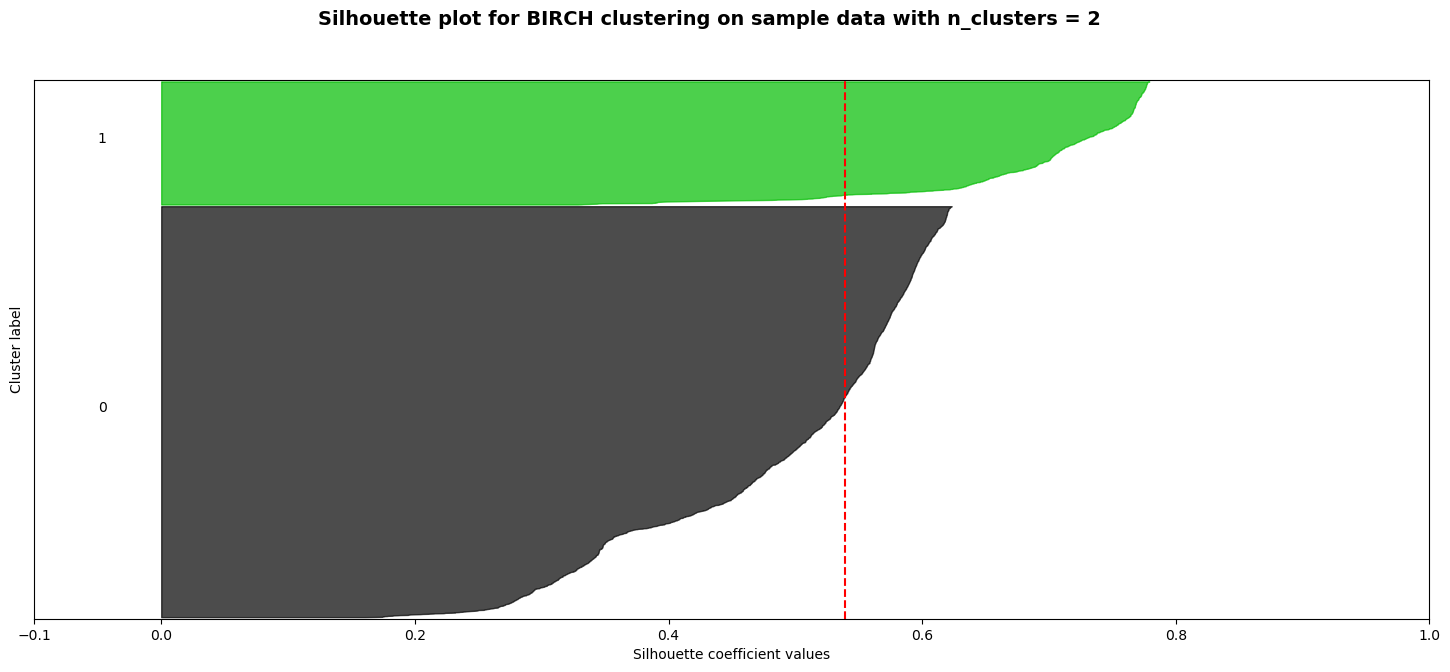

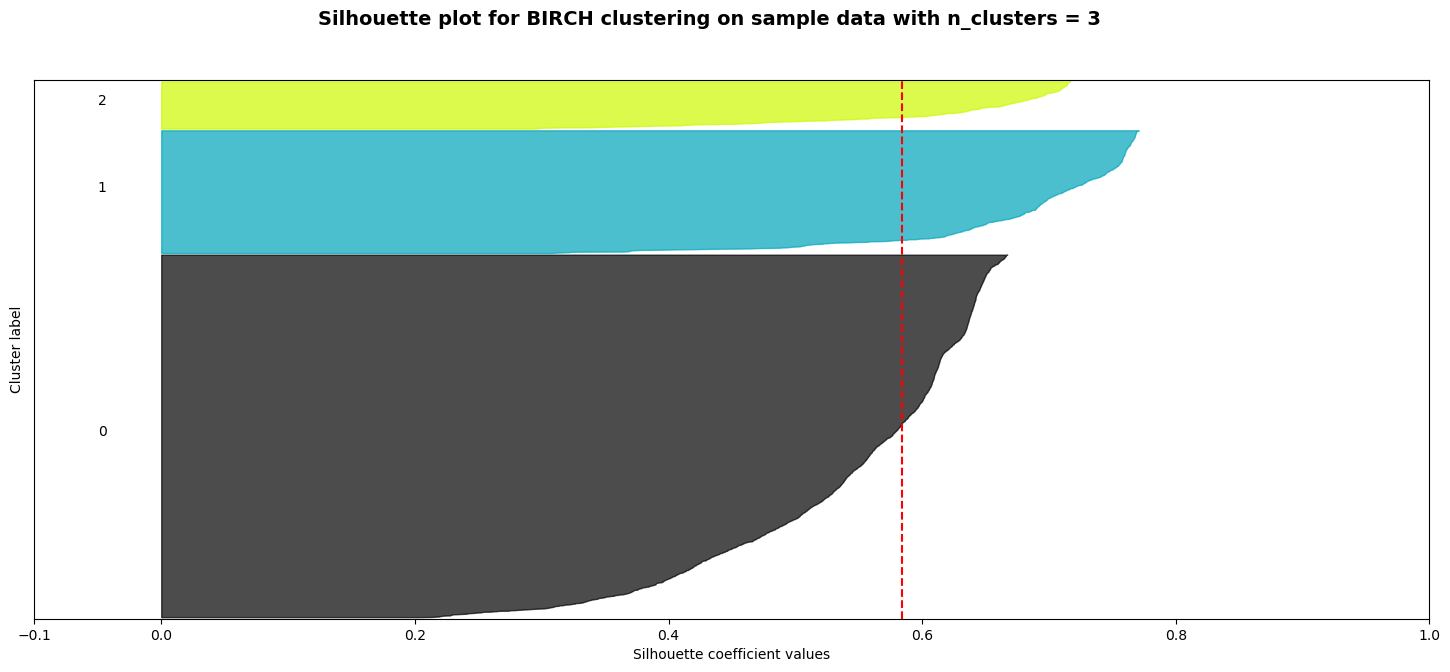

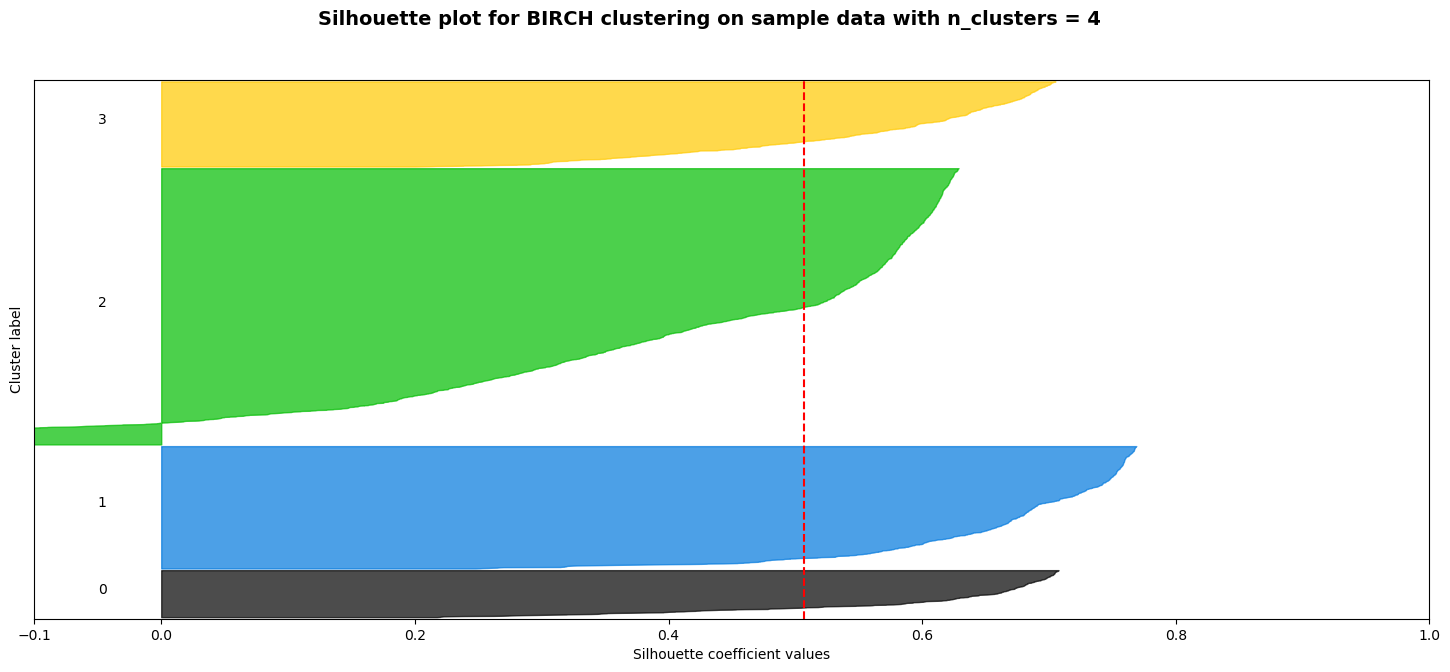

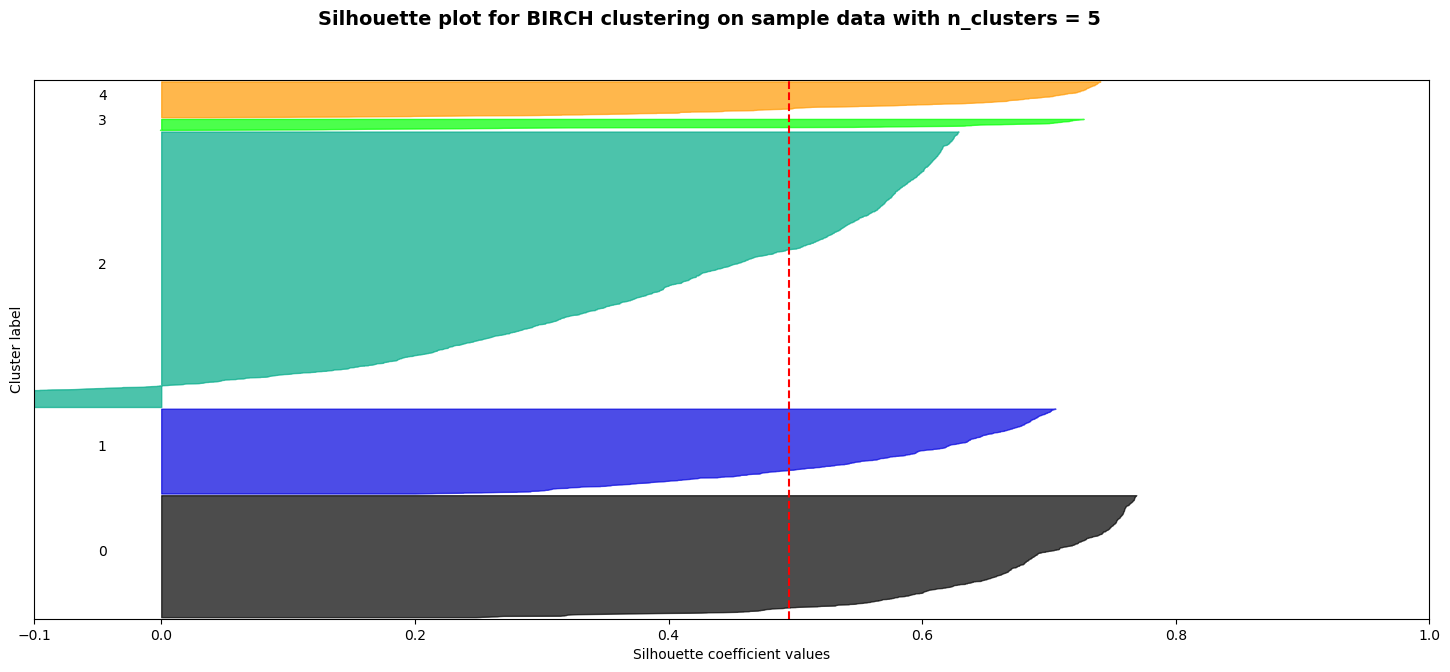

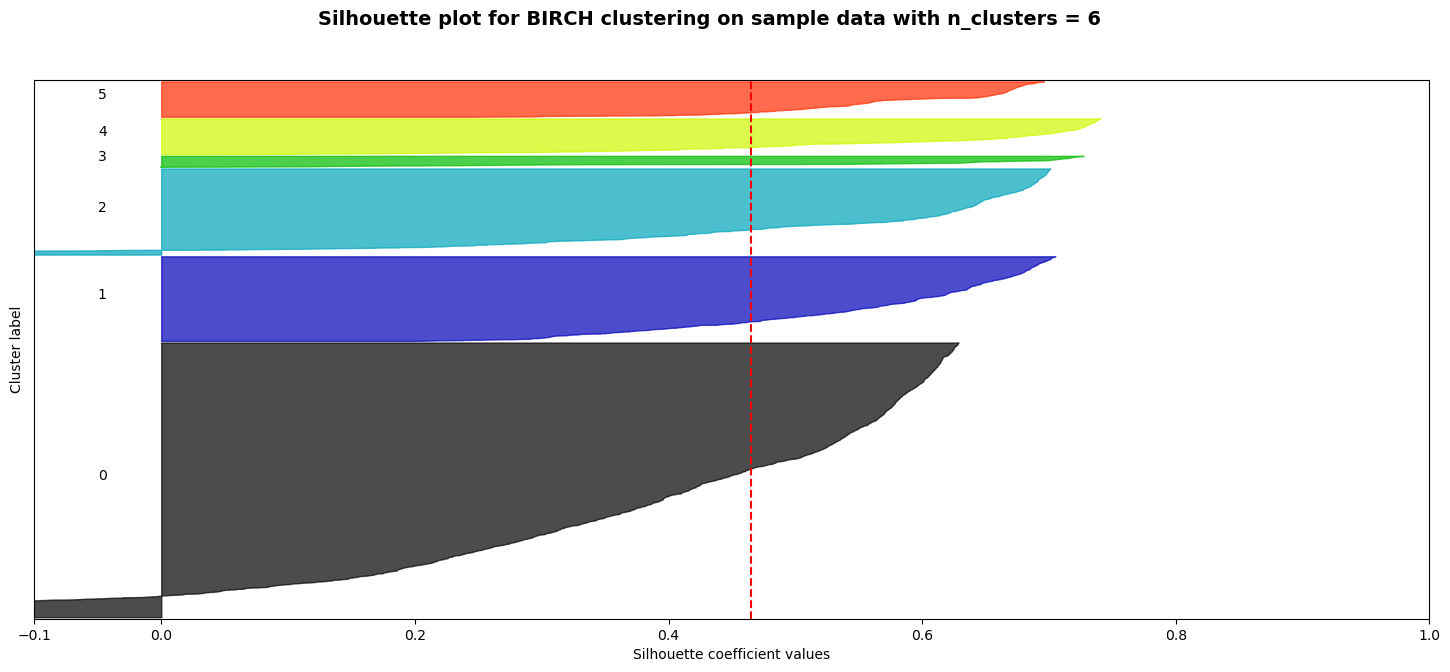

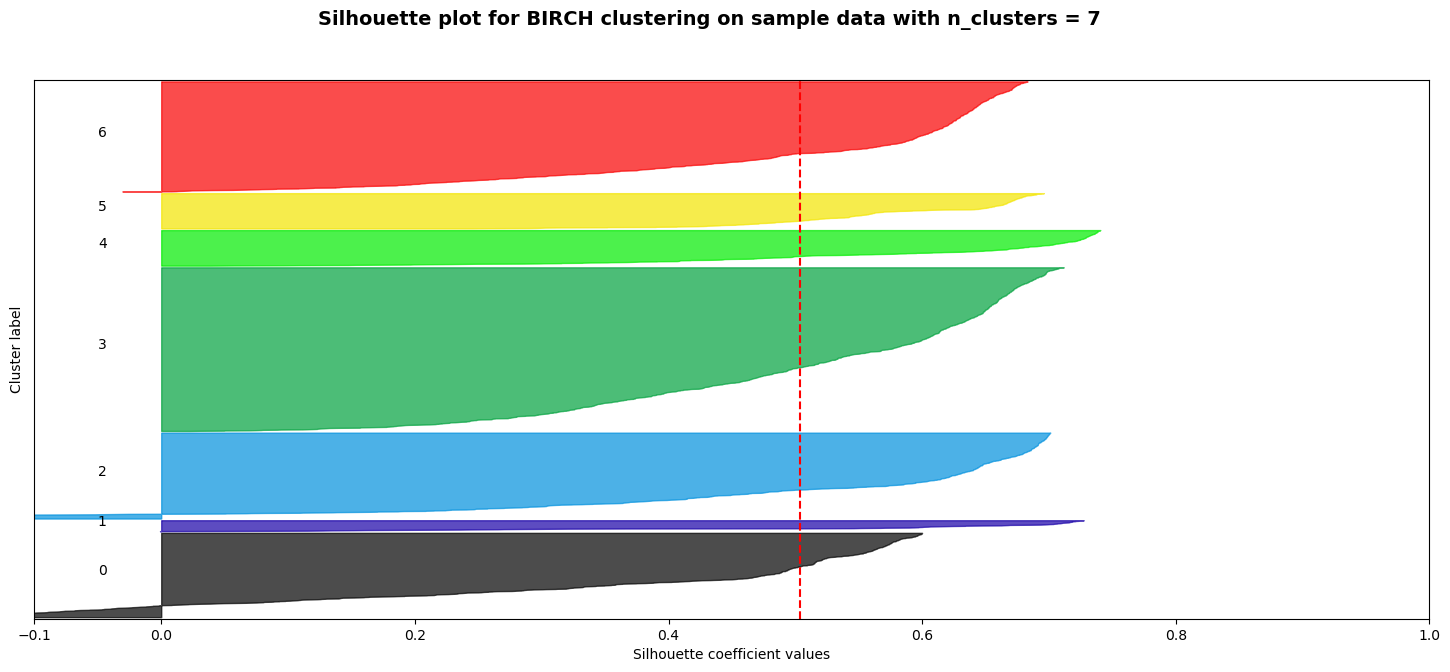

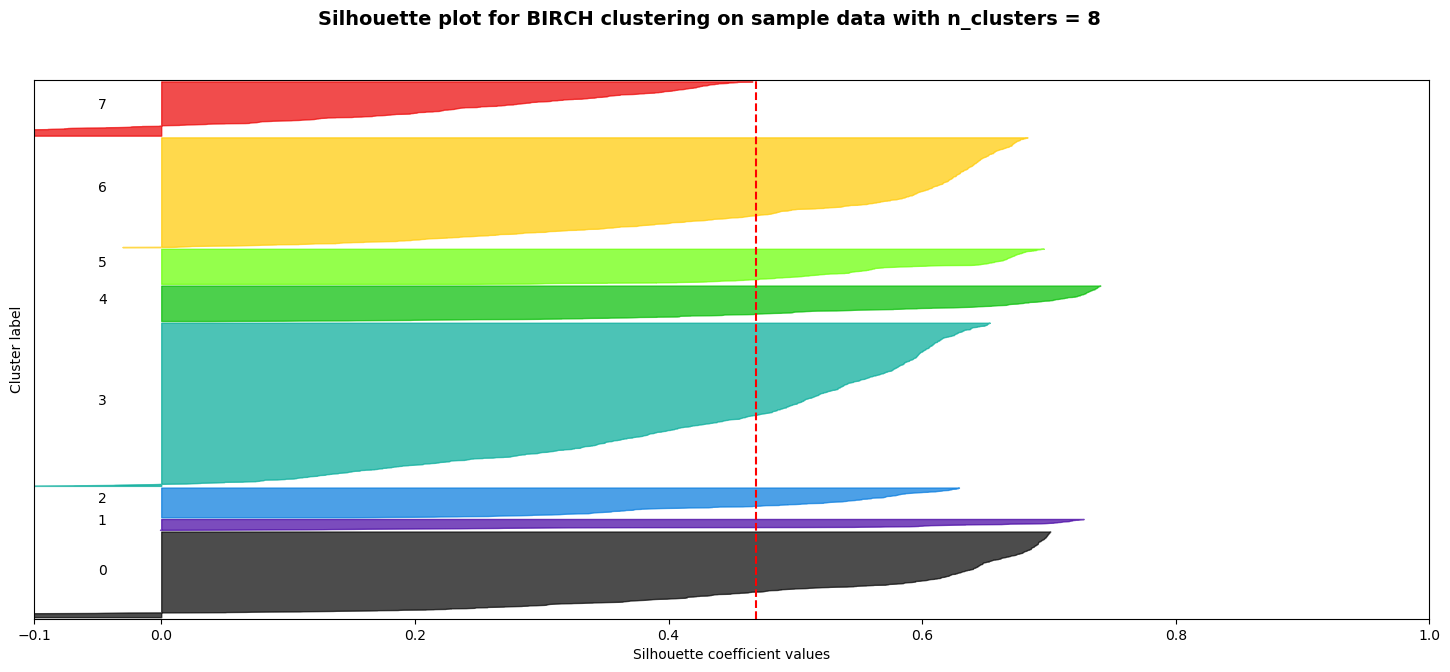

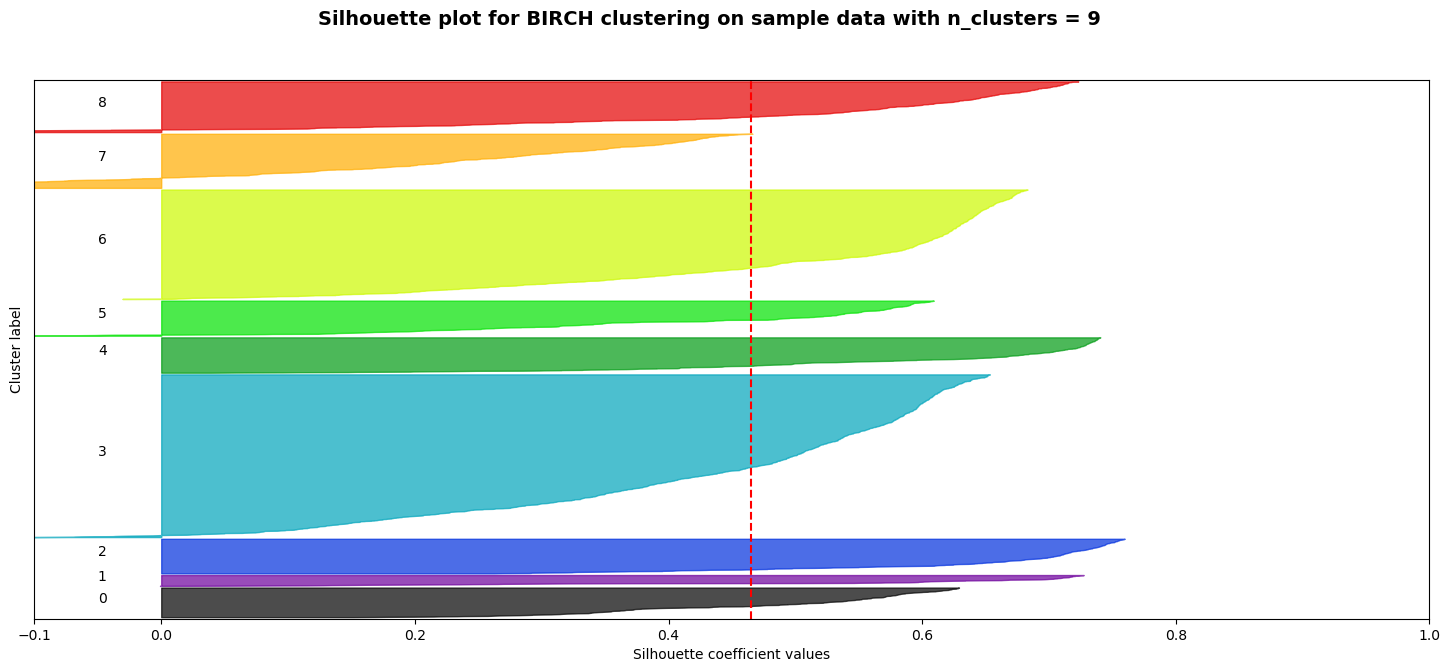

In [26]:
# Generate Silhouette scores and plot them
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot. The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(pcs_df) + (n_clusters + 1) * 10])
    
    # Initialize the clusterer with n_clusters value
    clusterer = Birch(threshold=th, branching_factor=bf, n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(pcs_df)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(pcs_df, cluster_labels)
    print("For n_clusters =",n_clusters,"The average silhouette_score is :",silhouette_avg,)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(pcs_df, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

 # ax2 code here

    plt.suptitle(
        "Silhouette plot for BIRCH clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [27]:
# Initialize the parameters for the model below
nc = 3   #:n_clusters - default is 3

# Use the Threshold and Branching values passed into the Silhouette plotting for consistency.

## BIRCH

In [28]:
# define the model
model = Birch(threshold=th, branching_factor=bf, n_clusters=nc)

# Create a copy of the pcs_df for processing below
b_pcs_df = pcs_df.copy()

# Fit the model - Make predictions
pred = model.fit_predict(b_pcs_df)

# Add the predicted class columns
b_pcs_df['class'] = model.labels_
b_pcs_df.head(40)

pc1       pc2       pc3  class
0  -0.119160 -0.410687 -0.342319      0
1  -0.115226 -0.415236 -0.344134      0
2  -0.111570 -0.419477 -0.345866      0
3  -0.107517 -0.424180 -0.347671      0
4  -0.067714 -0.488810 -0.339913      0
5  -0.064044 -0.492863 -0.341829      0
6  -0.062814 -0.495755 -0.341462      0
7  -0.058149 -0.504793 -0.339926      0
8  -0.057678 -0.506505 -0.339665      0
9  -0.057074 -0.508257 -0.339520      0
10 -0.056183 -0.510509 -0.339287      0
11 -0.058017 -0.511051 -0.336937      0
12 -0.059948 -0.511362 -0.334652      0
13 -0.062067 -0.511352 -0.332419      0
14 -0.061825 -0.515512 -0.329419      0
15 -0.062066 -0.518822 -0.326577      0
16 -0.060530 -0.522483 -0.325939      0
17 -0.054604 -0.527268 -0.330191      0
18 -0.052554 -0.531718 -0.329464      0
19 -0.051391 -0.533702 -0.329078      0
20  0.636938  0.402688  0.119827      1
21  0.642693  0.393428  0.120830      1
22  0.647586  0.385392  0.121780      1
23  0.649374  0.382560  0.121824      1
24  0.654748  0.373831  0.122841      1
25  0.658208  0.368383  0.123231      1
26  0.660963  0.363182  0.124452      1
27  0.666511  0.353164  0.126506      1
28  0.667520  0.351336  0.127028      1
29  0.677626  0.333608  0.130370      1
30  0.678977  0.330476  0.131374      1
31  0.720698  0.261540  0.141520      1
32  0.722159  0.259777  0.141166      1
33  0.727325  0.251676  0.141853      1
34  0.733762  0.241480  0.142910      1
35  0.737816  0.235009  0.143433      1
36  0.736885  0.236177  0.143389      1
37  0.736293  0.237346  0.142986      1
38  0.738510  0.233510  0.143638      1
39  0.741428  0.228600  0.144438      1

In [30]:
# Create a new DataFrame including predicted clusters and demographic features.
frames = [country_year_df, combined_df, b_pcs_df]
clustered_df = pd.concat(frames, axis=1, join='outer')
#clustered_df.index = combined_df.index
clustered_df = clustered_df.set_index('country_year', drop=False)

# Drop the string column
clustered_df = clustered_df.drop(['system_type'], axis=1)

# Print the shape of the clustered_df
print(clustered_df.shape)
clustered_df.head(30)

(3379, 15)


country_year  Life Expectancy  Alcohol Consumption  \
country_year                                                       
Albania 2000  Albania 2000             75.0                 6.57   
Albania 2001  Albania 2001             75.0                 6.79   
Albania 2002  Albania 2002             75.0                 7.00   
Albania 2003  Albania 2003             75.0                 7.22   
Albania 2004  Albania 2004             80.0                 7.43   
Albania 2005  Albania 2005             80.0                 7.65   
Albania 2006  Albania 2006             80.0                 7.66   
Albania 2007  Albania 2007             80.0                 7.67   
Albania 2008  Albania 2008             80.0                 7.67   
Albania 2009  Albania 2009             80.0                 7.68   
Albania 2010  Albania 2010             80.0                 7.69   
Albania 2011  Albania 2011             80.0                 7.50   
Albania 2012  Albania 2012             80.0                 7.31   
Albania 2013  Albania 2013             80.0                 7.12   
Albania 2014  Albania 2014             80.0                 6.93   
Albania 2015  Albania 2015             80.0                 6.74   
Albania 2016  Albania 2016             80.0                 6.74   
Albania 2017  Albania 2017             80.0                 7.17   
Albania 2018  Albania 2018             80.0                 7.17   
Albania 2019  Albania 2019             80.0                 7.17   
Algeria 2000  Algeria 2000             75.0                 0.58   
Algeria 2001  Algeria 2001             75.0                 0.63   
Algeria 2002  Algeria 2002             75.0                 0.67   
Algeria 2003  Algeria 2003             75.0                 0.72   
Algeria 2004  Algeria 2004             75.0                 0.76   
Algeria 2005  Algeria 2005             75.0                 0.81   
Algeria 2006  Algeria 2006             75.0                 0.78   
Algeria 2007  Algeria 2007             75.0                 0.75   
Algeria 2008  Algeria 2008             75.0                 0.71   
Algeria 2009  Algeria 2009             75.0                 0.68   

              Tobacco Consumption  GDP per Capita  \
country_year                                        
Albania 2000                35.00         1960.88   
Albania 2001                34.26         2143.53   
Albania 2002                33.52         2247.50   
Albania 2003                32.78         2380.64   
Albania 2004                32.04         2522.45   
Albania 2005                31.30         2675.51   
Albania 2006                30.64         2851.37   
Albania 2007                29.98         3044.90   
Albania 2008                29.32         3298.48   
Albania 2009                28.66         3432.17   
Albania 2010                28.00         3577.11   
Albania 2011                27.42         3678.05   
Albania 2012                26.84         3736.34   
Albania 2013                26.26         3780.70   
Albania 2014                25.68         3855.76   
Albania 2015                25.10         3952.80   
Albania 2016                24.40         4090.37   
Albania 2017                23.70         4249.80   
Albania 2018                23.00         4431.54   
Albania 2019                23.10         4543.39   
Algeria 2000                22.20         3138.23   
Algeria 2001                22.12         3188.21   
Algeria 2002                22.04         3321.64   
Algeria 2003                21.96         3512.90   
Algeria 2004                21.88         3612.75   
Algeria 2005                21.80         3774.07   
Algeria 2006                21.74         3783.31   
Algeria 2007                21.68         3848.78   
Algeria 2008                21.62         3874.37   
Algeria 2009                21.56         3866.30   

              Goverment Expenditure per Capita  \
country_year                                     
Albania 2000                            

In [31]:
# Creating a Scatter with the scale_encode_df data and the clusters
fig = px.scatter_3d(clustered_df, x='sss_depth', y='Alcohol Consumption', z='Goverment Expenditure per Capita', color='class', hover_name='country_year', hover_data=['Life Expectancy','Population','GDP per Capita'], width=800)
fig.show()

In [ ]:
# Creating a Scatter with the scale_encode_df data and the clusters
fig = px.scatter_3d(clustered_df, x='tot_alcohol_consumption', y='private_he', z='govt_he',size='both_sexes_lex', color='class',symbol='sss_depth', hover_name='country', hover_data=['both_sexes_lex','Population (M) 2022','GDP(M$)'], width=800)
fig.show()

In [32]:
# Create the inference data for the autocorrelation plot
clustered_list_df = clustered_df.copy()

data_list = clustered_list_df[['sss_depth', 'Life Expectancy']].values

df = pd.DataFrame({'a':data_list[:,0], 'b':data_list[:,1]})
df["chain"] = 0
df["draw"] = np.arange(len(df), dtype=int)
df = df.set_index(["chain", "draw"])
xdata = xr.Dataset.from_dataframe(df)

dataset_list = az.InferenceData(posterior=xdata)
dataset_list

Inference data with groups:
	> posterior

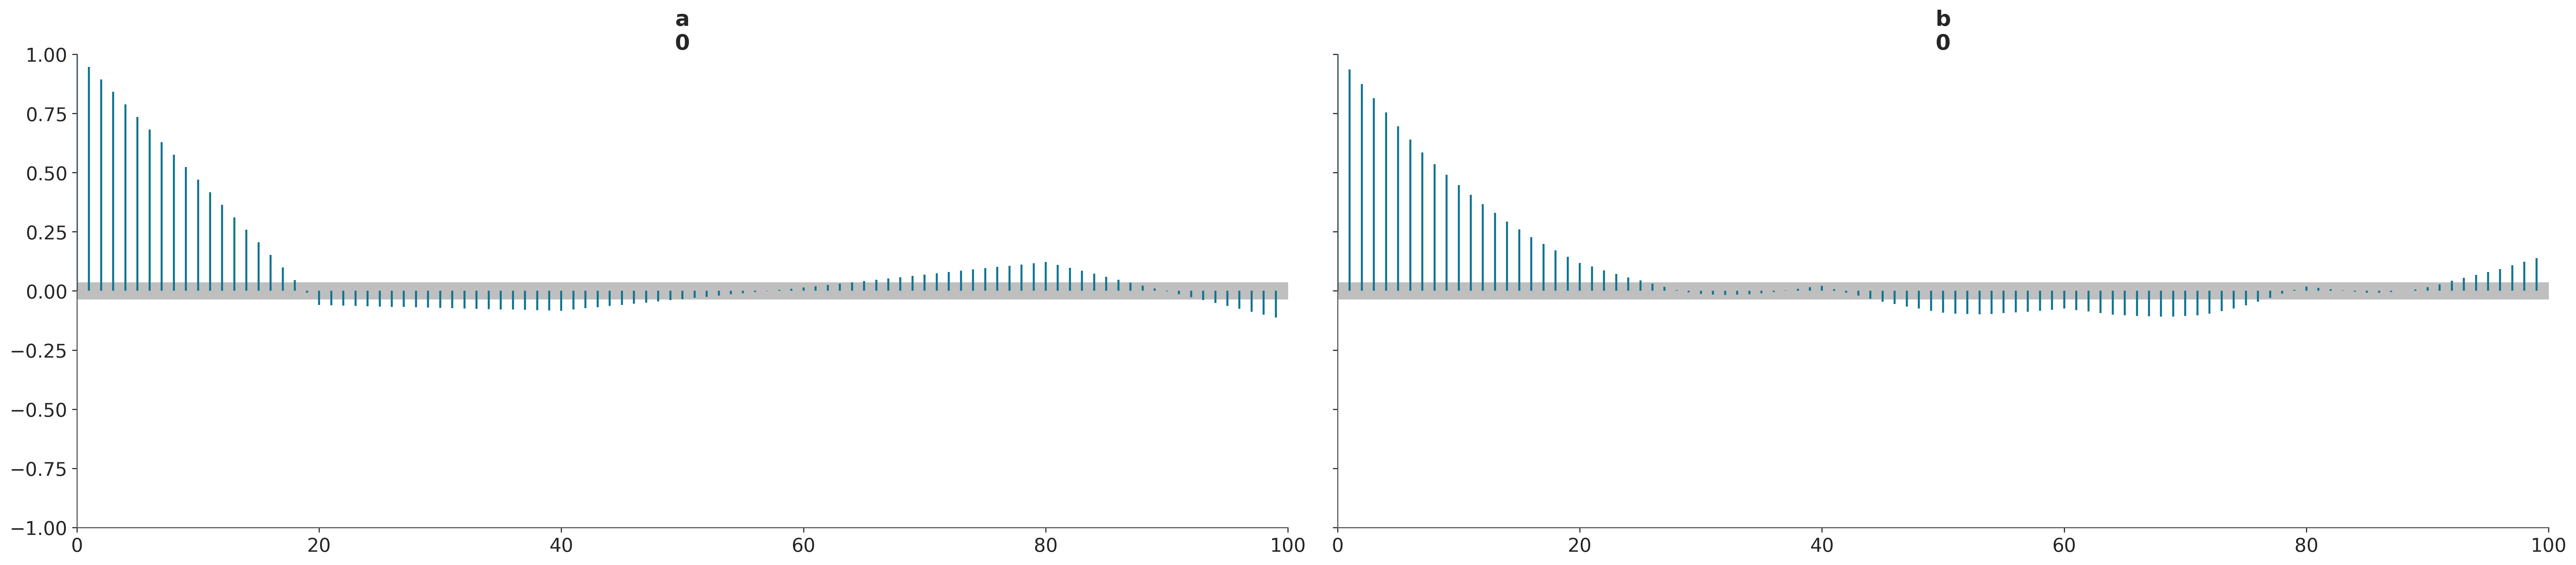

In [33]:
# Create an autocorrelation plot
az.style.use("arviz-doc")

az.plot_autocorr(dataset_list, var_names=('a', 'b'))

plt.show()

In [34]:
# Create a hvplot.scatter plot.
sizez = clustered_df['sss_depth'] * 30

clustered_df.hvplot.scatter(x='class', y='Life Expectancy', label='List BIRCH', size=sizez, hover_cols=['country_year'], line_color='#c994c7', hover_line_color='magenta', by='class')

:NdOverlay   [class]
   :Scatter   [class]   (Life Expectancy,_size,country_year)

In [35]:
# Create a hvplot.scatter plot.
sizez = clustered_df['sss_depth'] * 30

clustered_df.hvplot.scatter(x='Alcohol Consumption', y='Life Expectancy', label='List BIRCH', size=sizez, hover_cols=['country_year'], line_color='#c994c7', hover_line_color='magenta', by='class')

:NdOverlay   [class]
   :Scatter   [Alcohol Consumption]   (Life Expectancy,_size,country_year)

In [41]:
# Create a hvplot.kde plot.
columns=['Alcohol Consumption', 'Tobacco Consumption', 'Life Expectancy']
clustered_df.hvplot.kde(y=columns, alpha=0.5, value_label='% of Population', legend='top')

:NdOverlay   [Variable]
   :Distribution   [% of Population]   (Density)

In [ ]:
# Create a hvplot.kde plot with regression lines
columns=['Alcohol Consumption', 'Tobacco Consumption']
clustered_df.hvplot.kde(y=columns, alpha=0.5, value_label='% of Population', legend='top')

In [63]:
clustered_df.hvplot.area(x='Life Expectancy', y='sss_depth', label='% of Computer Science Degrees Earned by Women',
                 ylim=(0,6), width=500, height=400)

:Area   [Life Expectancy]   (sss_depth)

In [51]:
# Example HV scatter plot with regression line
# create random data
xpts = np.arange(0, 20)
ypts = gradient * xpts + y_intercept + np.random.normal(0, 4, 20)

scatter = hv.Scatter((xpts, ypts))
#slope = hv.Slope(gradient, y_intercept)
slope = hv.Slope.from_scatter(scatter)

scatter.opts(size=5) * slope.opts(color='red', line_width=2)

:Overlay
   .Scatter.I    :Scatter   [x]   (y)
   .Annotation.I :Slope   [x,y]

In [61]:
ypts.dtype()

TypeError: 'numpy.dtype[float64]' object is not callable

In [59]:
# Try HV scatter plot with my data and regression line

columns=('sss_depth', 'Life Expectancy')

scatter = hv.Scatter(columns)
#slope = hv.Slope(gradient, y_intercept)
#slope = hv.Slope.from_scatter(scatter)

scatter.opts(size=5) # * slope.opts(color='red', line_width=2)

:Scatter   [x]   (y)

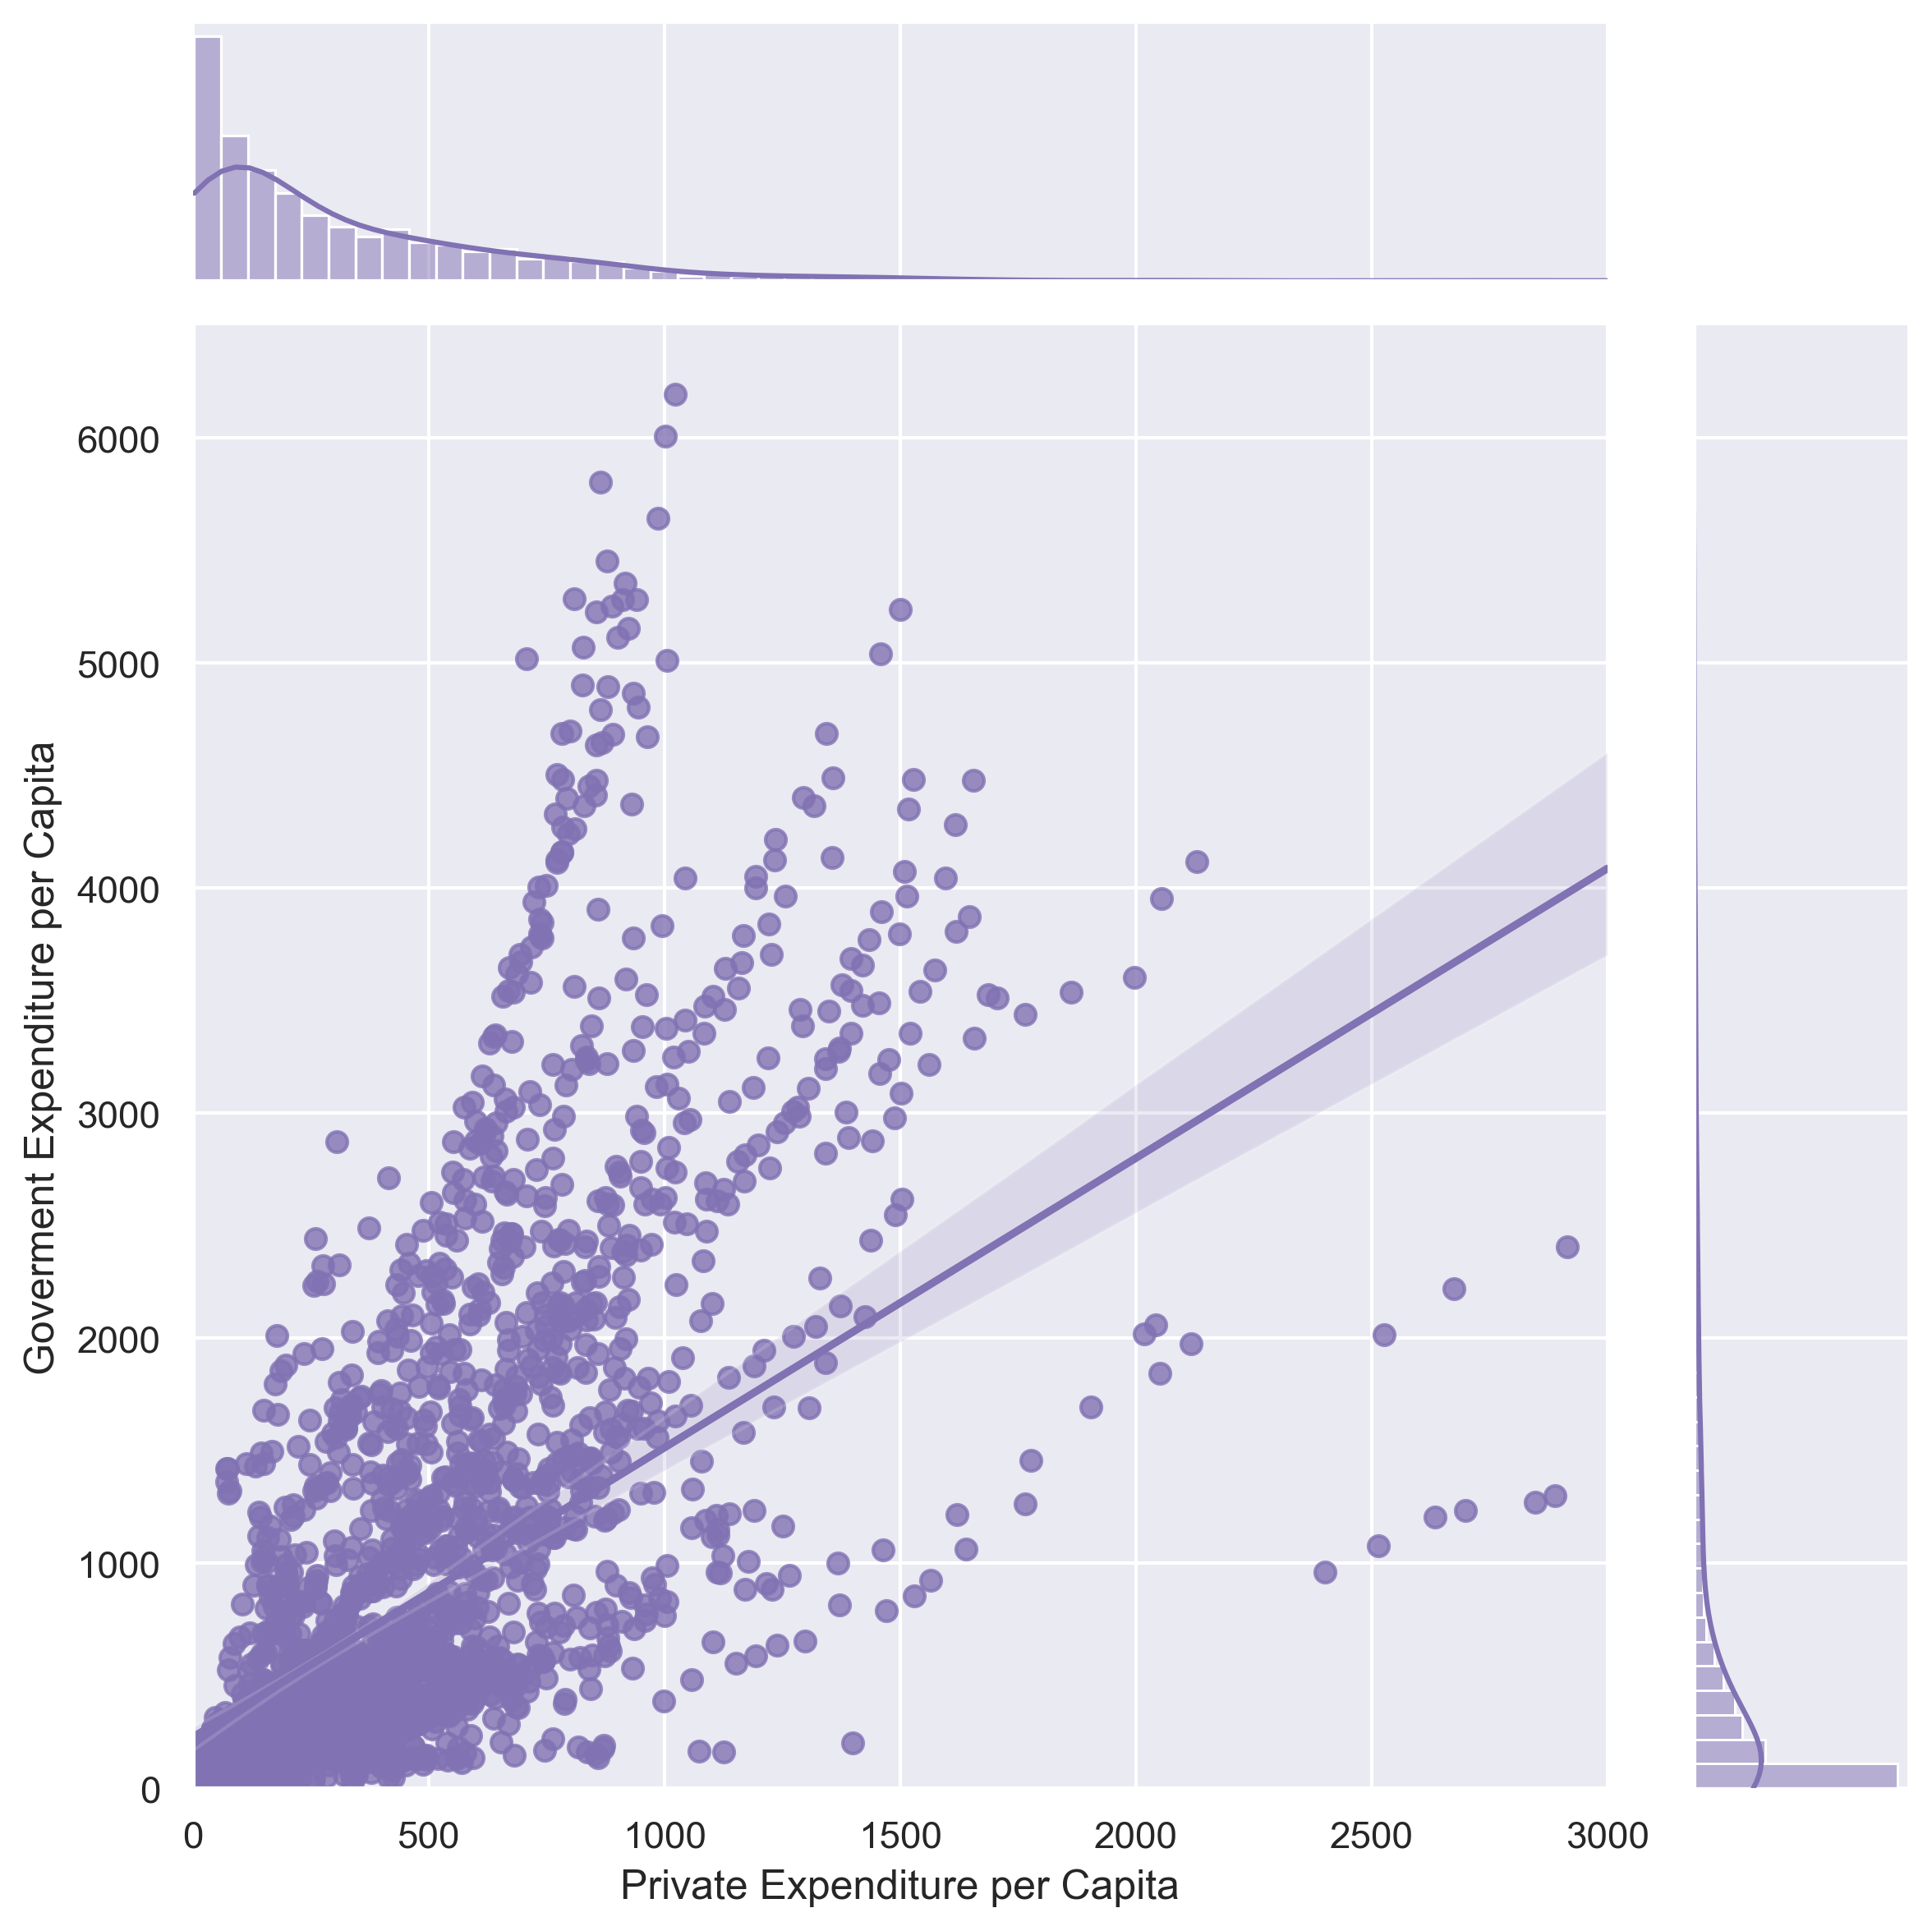

In [36]:
sns.set_theme(style="darkgrid")

g = sns.jointplot(x='Private Expenditure per Capita', y='Goverment Expenditure per Capita', data=clustered_df,
                  kind="reg", truncate=False,
                  xlim=(0, 3000), ylim=(0, 6500),
                  color='m', height=8)

In [ ]:
sns.set_theme(style="darkgrid")

# Plot 
g = sns.lmplot(
    data=clustered_df,
    x='tot_alcohol_consumption', y='both_sexes_lex', hue='sss_depth',
    height=5
)

# Use more informative axis labels than are provided by default
g.set_axis_labels('tot_alcohol_consumption', 'both_sexes_lex')

## Coded Input

In [ ]:
# get a reference to the data collection
data_code = db['clustering_final_system_coded_input']

In [ ]:
# Create a dataframe from the collection
combined_c_df = pd.DataFrame(list(data_code.find()))
combined_c_df

In [ ]:
# Drop the database id data and refresh the index
combined_c_df = combined_c_df.drop(['_id'], axis=1)
combined_c_df = combined_c_df.reset_index(drop=True)
combined_c_df

In [ ]:
# Set the DataFrame index to the country names to get them out of the way
combined_c_df = combined_c_df.set_index('country')
combined_c_df

# Coded - Encoding

In [ ]:
# Use get_dummies() to create variables for text features.
encode_c_df = pd.get_dummies(combined_c_df, columns=['s1','s2','s3','s4','s5'])
encode_c_df

In [ ]:
# Collect the column labels so they can be reapplied after data scaling
col_names_c = encode_c_df.columns.tolist()

# Coded - Scaling

In [ ]:
# Standardize the data with MinMaxScaler().
scaler = MinMaxScaler()

encode_scaled_c_nda = scaler.fit_transform(encode_c_df)
encode_scaled_c_nda

In [ ]:
# Convert the scaled-encoded data back to a DataFrame (nda = Numpy Data Array)

scale_encode_c_df = pd.DataFrame(encode_scaled_c_nda, index=encode_c_df.index)
scale_encode_c_df

In [ ]:
# Apply the column labels to ensure the data is properly identified
scale_encode_c_df = scale_encode_c_df.set_axis(col_names_c, axis=1)
scale_encode_c_df

## Coded - Feature Selection

In [ ]:
# Define the variance threshold (1%)
sel_c = VarianceThreshold(threshold=0.01)

# Apply the variance threshold to the scale_encode_c_df DataFrame
new_se_c = sel_c.fit_transform(scale_encode_c_df)

In [ ]:
# Create feature-reduce DataFrame
new_se_c_df = pd.DataFrame(new_se_c, index=encode_c_df.index)
new_se_c_df

In [ ]:
# Apply the column labels to the feature-reduced DataFrame
new_se_c_df.columns = sel_c.get_feature_names_out(col_names_c)
new_se_c_df

## Coded - PCA

In [ ]:
# Initialize the parameters with starter values
n_comp = 3 #:n_components - used for PCA
rs = 42  #:random_state

In [ ]:
# Using PCA to reduce dimension to the principal components.
pca = PCA(n_components=n_comp, random_state=rs)

# Get principal components for the feature-reduced demographics data
demo_pca_c = pca.fit_transform(new_se_c)
demo_pca_c

In [ ]:
# Create a DataFrame with the principal components.
columnz =[]

for i in range(1,n_comp+1):
    columnz.append('pc'+str(i))

pcs_c_df = pd.DataFrame(data=demo_pca_c, columns=columnz, index=new_se_c_df.index)
pcs_c_df

## Coded - Compute Silhouette scores and plots

In [ ]:
# BIRCH parameters
th = 0.5  #:threshold - setting this low promotes branching
bf = 50  #:branching factor (default is 50) - max number of CF subclusters in each node.

In [ ]:
# Generate Silhouette scores and plot them
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot. The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(pcs_c_df) + (n_clusters + 1) * 10])
    
    # Initialize the clusterer with n_clusters value
    clusterer = Birch(threshold=th, branching_factor=bf, n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(pcs_c_df)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(pcs_c_df, cluster_labels)
    print("For n_clusters =",n_clusters,"The average silhouette_score is :",silhouette_avg,)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(pcs_c_df, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

 # ax2 code here

    plt.suptitle(
        "Silhouette plot for (coded input) BIRCH clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [ ]:
# Initialize the parameters for the model below
nc = 5 #:n_clusters - default is 3

# Use the Threshold and Branching values passed into the Coded-Silhouette plotting for consistency.

## Coded - BIRCH

In [ ]:
# define the model
model = Birch(threshold=th, branching_factor=bf, n_clusters=nc)

# Create a copy of the pcs_df for processing below
b_pcs_df = pcs_c_df.copy()

# Fit the model - Make predictions
pred = model.fit_predict(b_pcs_df)

# Add the predicted class columns
b_pcs_df['class'] = model.labels_
b_pcs_df.head()

In [ ]:
# Create a new DataFrame including predicted clusters and demographic features.
frames = [country_df, combined_c_df, b_pcs_df]
clustered_c_df = pd.concat(frames, axis=1, join='outer')

# Drop the string column
clustered_c_df = clustered_c_df.drop(['s1','s2','s3','s4','s5'], axis=1)

# Print the shape of the clustered_df
print(clustered_c_df.shape)
clustered_c_df

In [ ]:
clustered_c_df = clustered_c_df.dropna()

# Convert the sss_depth back to integer type
clustered_c_df = clustered_c_df.astype({'sss_depth': int})
clustered_c_df.head(30)

In [ ]:
# Creating a Scatter with the scale_encode_df data and the clusters
fig = px.scatter_3d(clustered_c_df, x='sss_depth', y='tot_alcohol_consumption', z='govt_he_gdp', color='class', hover_name='country', hover_data=['both_sexes_lex','Population (M) 2022','GDP(M$)'], width=800)
fig.show()

In [ ]:
# Creating a Scatter with the scale_encode_df data and the clusters
fig = px.scatter_3d(clustered_c_df, x='tot_alcohol_consumption', y='private_he', z='govt_he',size='both_sexes_lex', color='class',symbol='sss_depth', hover_name='country', hover_data=['both_sexes_lex','Population (M) 2022','GDP(M$)'], width=800)
fig.show()

In [ ]:
# Create the inference data for the autocorrelation plot
clustered_code_df = clustered_c_df.copy()

data_code = clustered_code_df[['sss_depth', 'both_sexes_lex']].values

df = pd.DataFrame({'a':data_code[:,0], 'b':data_code[:,1]})
df["chain"] = 0
df["draw"] = np.arange(len(df), dtype=int)
df = df.set_index(["chain", "draw"])
xdata = xr.Dataset.from_dataframe(df)

dataset_code = az.InferenceData(posterior=xdata)
dataset_code

In [ ]:
# Create an autocorrelation plot
az.style.use("arviz-doc")

az.plot_autocorr(dataset_code, var_names=('a', 'b'))

plt.show()

In [ ]:
# Create a hvplot.scatter plot.
sizez = clustered_c_df['sss_depth'] * 30

clustered_c_df.hvplot.scatter(x='class', y='both_sexes_lex', size=sizez, label='Coded BIRCH', hover_cols=['country'], line_color='#c994c7', hover_line_color='magenta', by='class')

In [ ]:
# Create a hvplot.scatter plot.
sizez = clustered_c_df['sss_depth'] * 30

clustered_c_df.hvplot.scatter(x='tot_alcohol_consumption', y='both_sexes_lex', size=sizez, label='Coded BIRCH', hover_cols=['country'], line_color='#c994c7', hover_line_color='magenta', by='class')

In [ ]:
sns.set_theme(style="darkgrid")

g = sns.jointplot(x='private_he', y='govt_he', data=clustered_c_df,
                  kind="reg", truncate=False,
                  xlim=(0, 3000), ylim=(0, 6500),
                  color='blue', height=5)

In [ ]:
sns.set_theme(style="darkgrid")

# Plot 
g = sns.lmplot(
    data=clustered_c_df,
    x='tot_alcohol_consumption', y='both_sexes_lex', hue='sss_depth',
    height=5
)

# Use more informative axis labels than are provided by default
g.set_axis_labels('tot_alcohol_consumption', 'both_sexes_lex')

In [ ]:
az.plot_posterior(dataset_list)

In [ ]:
az.plot_posterior(dataset_code)

In [ ]:
az.plot_posterior(dataset_list, var_names=['a'], kind='hist')

In [ ]:
az.plot_posterior(dataset_code, var_names=['a'], kind='hist')

In [ ]:
az.plot_posterior(dataset_list, var_names=['b'], kind='hist')

In [ ]:
az.plot_posterior(dataset_code, var_names=['b'], kind='hist')

In [ ]:
hvexplorer = hvplot.explorer(clustered_c_df)
hvexplorer

## Comparison plots